# 3DEP Entwine Point Cloud Request Tutorial

This notebook demonstrates how to use the PDAL-based Modules to request 3DEP point clouds from cloud hosted services provided by the USGS, and turn those point clouds into grids and derivative products.

The USGS hosts point cloud data from its 3D Elevation Program (3DEP) and Earth MRI as free publically available files on entwine:
https://usgs.entwine.io/

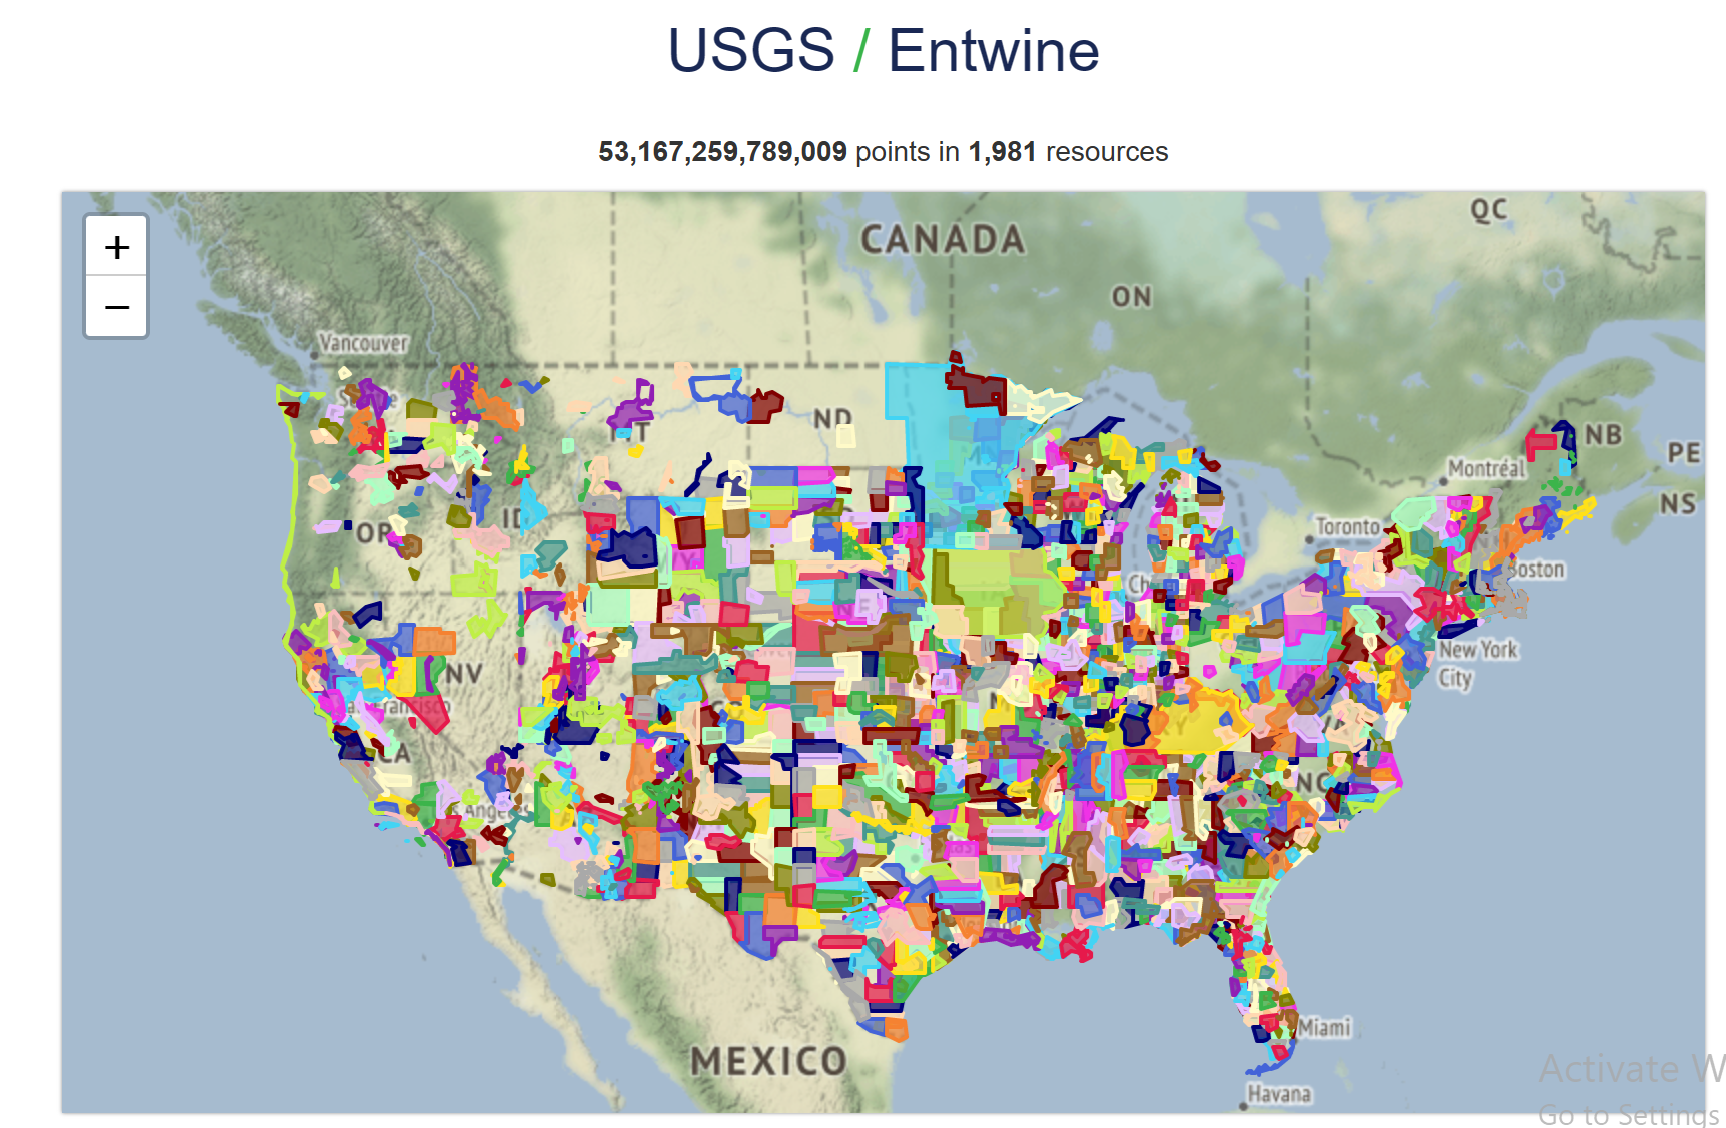

The two Python modules demCreationComponents and demAnalysisComponents allow you to directly request point clouds from available surveys and build DEMs in a python single script. 

** Web-based Lidar and DEM Processing is available through the 3DEP Lidar Explorer Map: https://apps.nationalmap.gov/lidar-explorer/#/


### This tutorial has three sections:
1. Build a DEM from requested point clouds
2. Generate point-cloud profiles using line shapefiles
3. Tile large pointcloud requests and generate DEM derivatives

In [1]:
import sys
import os

print(os.getcwd())
print(os.path.abspath(os.curdir))
os.chdir("..")
print(os.path.abspath(os.curdir))

sys.path.append('Modules/demAnalysisComponents/') #Add the path to the demAnalysis scripts
sys.path.append('Modules/demCreationComponents/')

print(os.getcwd())

import dem as dg #
import pointCloudCreation as pCC
import baseGrid as bg
from matplotlib import pyplot as plt
import numpy as np

from importlib import reload


/workspaces/rgr/src/notebook_tutorials
/workspaces/rgr/src/notebook_tutorials
/workspaces/rgr/src
/workspaces/rgr/src


### 1. Build a DEM from requested point clouds

Here we will build a by requesting point clouds from an available survey, then processing it using the demCreationComponents Module. 

This step will be time-intensive. 

The following information is needed:

1) Locate the available survey from your area of interest using the Entwine map:  https://usgs.entwine.io/

2) Determine the extent of your the data request in Decimal Degrees. (You can use an ArcGIS basemap or Google Earth to determine the extent coordinates: https://earth.google.com/web/ )

3) Determine the input and desired output EPSGs for the data

### In this example, we will use point clouds from the 'CO_San-Luis-Valley_2011' USGS survey between the Sand Dunes Nat'l Park and Blanca Peak in Southern Colorado.




In [2]:
testExtent = ([-105.602157,-105.548255],[37.606802,37.649582]) #Define an extent to request
testEPSG = 4326 #Define the SRS of the extent
outEPSG = 32613 #Define the output SRS

grid_name_dem = os.path.join('testData','test_slv_5_1_23') #Add the folder & DEM filename to save the data
grid_name_hag = os.path.join('testData','test_slv_hag') #Where do we want to save the data for the HAG?
usgs_survey_name = 'CO_San-Luis-Valley_2011' #What is the name of the dataset we are requesting from? Found at: https://usgs.entwine.io/
cell_size = 2.0 #Pixel size of resultant raster

#### Build DEM
#First get the JSON request description
pipeline = pCC.request_build_dem_creation_pipeline(testExtent,testEPSG,outEPSG,grid_name_dem,
                                                   usgs_survey_name,cell_size = cell_size)
pCC.run_pipeline(pipeline) #Then execute this request

### Build a height above ground raster (e.g., cannopy height)
#First get the JSON request description
pipeline = pCC.request_build_hag_creation_pipeline(testExtent,testEPSG,outEPSG,grid_name_hag,usgs_survey_name,
                                                   cell_size = cell_size)
pCC.run_pipeline(pipeline) #Execute the request

Now, visualize the DEM:

[Text(0, 4162000.0, ''),
 Text(0, 4163000.0, ''),
 Text(0, 4164000.0, ''),
 Text(0, 4165000.0, ''),
 Text(0, 4166000.0, ''),
 Text(0, 4167000.0, ''),
 Text(0, 4168000.0, '')]

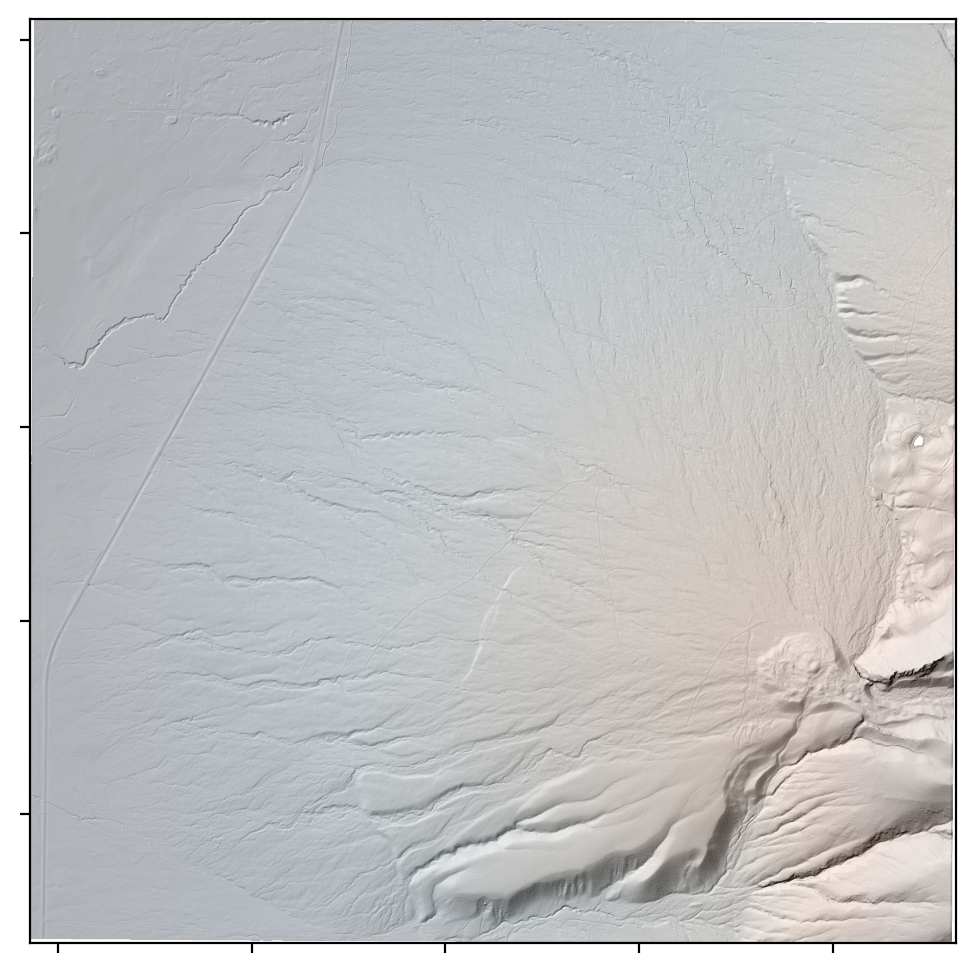

In [3]:
dem= dg.demGrid([],rasterPath=grid_name_dem+'.tif') # save the DEM as a tif file
dem[dem <0] = np.nan # remove NoDATA value pixels from the DEM

hs = dem.calcHillshade() # compute a hillshade map
hag = dg.demGrid([],rasterPath = grid_name_hag+'.tif')

f,axs = plt.subplots(1,1,figsize = (6,6),dpi = 200,sharex=True,sharey=True)
#Plot the hillshade
hs.plotGrid(axs = axs,cmap = 'gray',vmin = 0, vmax = 255)
#Plot the DEM as two different very transparent colormaps, just to play with overlay effects
dem.plotGrid(axs = axs,cmap = 'Blues_r',alpha = 0.1, vmin = 2340, vmax = 2750)
dem.plotGrid(axs = axs,cmap = 'Oranges',alpha = 0.1, vmin = 2500, vmax = 2950)

#Remove axis labels for clean axes
axs.set_xticklabels([])
axs.set_yticklabels([])


### 2. Requesting point cloud profiles

It's also possible to request swath profiles of point clouds from lines, for example the fault scarp present in the middle of the alluvial fan above.

/workspaces/rgr/src


[Text(0, 4162000.0, ''),
 Text(0, 4163000.0, ''),
 Text(0, 4164000.0, ''),
 Text(0, 4165000.0, ''),
 Text(0, 4166000.0, ''),
 Text(0, 4167000.0, ''),
 Text(0, 4168000.0, '')]

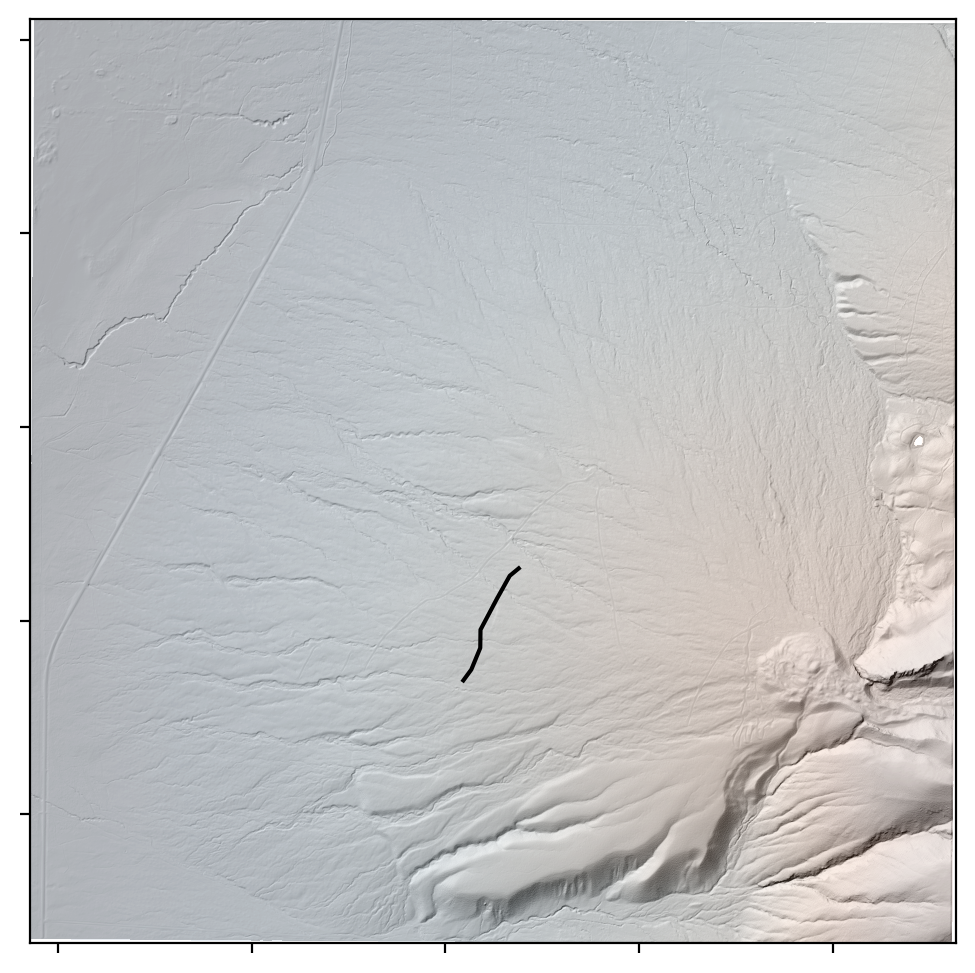

In [4]:
#First lets load in a trace of the fault scarp above
import geopandas as gpd
print(os.getcwd())

pathToFaultTrace = os.path.join('testData','vectorData','SLV_Zapata_FaultScarp.shp')

fsGDF = gpd.read_file(pathToFaultTrace)
f,axs = plt.subplots(1,1,figsize = (6,6),dpi = 200,sharex=True,sharey=True)

#Plot the hillshade
hs.plotGrid(axs = axs,cmap = 'gray',vmin = 0, vmax = 255)

#Plot the DEM as two different very transparent colormaps, just to play with overlay effects
dem.plotGrid(axs = axs,cmap = 'Blues_r',alpha = 0.1, vmin = 2340, vmax = 2750)
dem.plotGrid(axs = axs,cmap = 'Oranges',alpha = 0.1, vmin = 2500, vmax = 2950)

#Plot the fault scarp
fsGDF.plot(ax = axs,color = 'k')

#Remove axis labels for clean axes
axs.set_xticklabels([])
axs.set_yticklabels([])

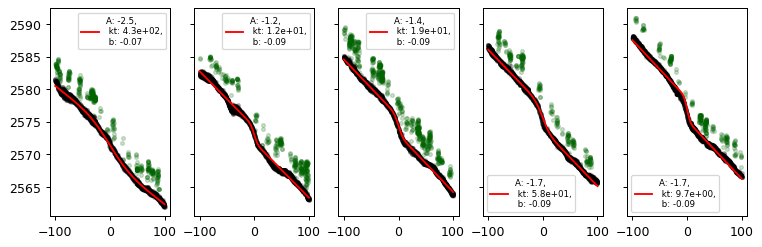

In [5]:
#Here we will request a series of orthogonal profiles to the line above
from scipy.special import erf
from scipy import optimize
from importlib import reload
reload(pCC)

nSwaths = 5 #Number of orthogonal profiles we will construct
swathPositions = np.linspace(0,1,nSwaths) #Relative positions along the line of the swaths

faultLine = fsGDF.geometry[0] #Get the line geometry

swathLength = 200.0
swathWidth = 3.0

f,axs = plt.subplots(1,nSwaths,figsize = (10,3),dpi = 90,sharex = True,sharey = True)

#Functions for fitting fault scarp morphology using simple-scarp diffusion:
def fsFun(L,params):
    #Solution for a scarp on an inclined surface smoothed by linear diffusion
    a,kt,b,c = params
    return a*erf((L)/(2.0*np.sqrt(kt))) + b*(L) + c

def fitFS(L,Z):
    #Optimizing for the best fitting paramaters in the above scarp profile solution
    objFun = lambda params : np.sum((Z - fsFun(L,params))**2)
    paramGuess = [1.0,10,0.0,np.mean(Z)]
    
    res = optimize.minimize(objFun,paramGuess).x
    return res


for i,relative_position in enumerate(swathPositions):
    
    
    #Execute the pipeline
    pipe = pCC.get_orthogonal_swathprofile_request_pointcloud(faultLine,
                                                             relative_position, swathLength,
                                                             swathWidth,outEPSG,
                                                             usgs_survey_name,
                                                             'profileTest',doSavePointCloud=False,
                                                            doReclassify = True)
    #Get the relevant data from the pipeline
    arrays = pipe.arrays[0]
    L = np.array(arrays['L']) - swathLength/2.0
    Z = np.array(arrays['Z'])
    C = np.array(arrays['Classification'])
    D = np.array(arrays['D'])
    X = np.array(arrays['X'])
    Y = np.array(arrays['Y'])
    
    #Which points are ground:
    isGrnd = C == 2
    
    #Fit the fault scarp
    bfParams = fitFS(L[isGrnd],Z[isGrnd])
    
    #Create a predicted FS line
    LtoFit = np.linspace(-swathLength/2.0,swathLength/2.0,50)
    Zfit = fsFun(LtoFit,bfParams)
    
    #Plot the result
    axs[i].plot(L[~isGrnd],Z[~isGrnd],'.',color = 'darkgreen',alpha =0.2)
    axs[i].plot(L[isGrnd],Z[isGrnd],'.',color = 'k',alpha =0.2)
    axs[i].plot(LtoFit,Zfit,'-r',label = 'A: {:.1f},\n kt: {:.1e},\n b: {:.2f}'.format(bfParams[0],bfParams[1],bfParams[2]))
    
    axs[i].legend(fontsize = 'x-small')
    


### 3. Tiling large requests

When making large requests it can be prohibitively slow to grab all the points of interest at once. Instead we will tile our request, selecting point clouds in a moving window, building DEMs from them, and then merging the DEMs.

In [2]:
#Now for a larger request we want to tile that request
#extent = ([-105.602157,-105.548255],[37.606802,37.649582]) #([MinX,MaxX],[MinY,MaxY])
extent = ([-105.5994,-105.548255],[37.5919,37.7026])
extentEPSG = 4326 #SRS for extent
outEPSG = 32613 #SRS for output

grid_name = os.path.join('testData','tileTestBig','HBack') #Create new folder for savinf tiled grids
usgs_survey_name = 'CO_San-Luis-Valley_2011' #Name of source dataset
cell_size = 2.0 #What is the x,y pixel dimension for each grid?
tileWidth = 1e3 #How wide is each tile
tileOverlap = 10*cell_size #How much should each tile overlap

doKeepTiles = False #Do we want to keep the original tiles that were created?
doBuildDEMDerivatives = True #Do we want to build derivatives for DEMs?

#Paramaters for DEM derivatives
HS_AZ = 315 #Hillshade azimuth
HS_ELV = 45 #HS elevation angle
TPI_IN_MULT = 2 #Multiplier on cell size for inner annulus radius of TPI
TPI_OUT_MULT = 4 #Multiplier on cell size for outer annulus radius of TPI
SLOPE_WIN = 1 #Window size for slope magnitude kernel
CRV_WIN = 2 #Window size for second derivative kernel

### Define the routine we want to use in each tile to get point cloud tiles
pipeline_builder = lambda ext,ext_epsg,name: pCC.request_build_dem_creation_pipeline(ext,ext_epsg,pCC.ENTWINE_EPSG,name,
                                                                                  usgs_survey_name,cell_size)
#Get list of each tiled request pipeline to make
tiled_pipelines = pCC.get_tiled_request_pipelines(extent,extentEPSG,tileWidth,tileOverlap,grid_name,pipeline_builder)

#loop through and run the pipelines - using something like joblib / parallel this could be made embarassingly parallel
for i,pipeline in enumerate(tiled_pipelines):
    thisGrid = pipeline['pipeline'][-1]['filename']
    print('Working on tile {} of {}, name: {}'.format(i+1,len(tiled_pipelines),thisGrid))
    pCC.run_pipeline(pipeline)

### Once all the tiles are created, merge them
outExtent = pCC.reproject_extent(extent,extentEPSG,outEPSG)
dem_tile_names = [p['pipeline'][-1]['filename'] for p in tiled_pipelines]

print('Merging tiles into one DEM...')
pCC.merge_warp_dems(dem_tile_names,grid_name+'.tif',outExtent,outEPSG,cell_size,noDataValue = np.nan)


print('Tiles merged...')
#Delete the individual tiles if necessary
if not(doKeepTiles):
    print('Deleting tiles...')
    for i,fname in enumerate(dem_tile_names):
        os.remove(fname)

if doBuildDEMDerivatives:
    dem = dg.demGrid([], rasterPath=grid_name + '.tif')
    print('Loaded DEM, Building derivatives...')

    #Hillshade
    print('Building Hillshade...')
    HS = dem.calcHillshade(HS_AZ,HS_ELV)
    HS.overwriteSaveFile()

    #Slope magnitude
    print('Building Slope magnitude...')
    Smag = dem.calcFiniteSlopeMagOverWindow(SLOPE_WIN)
    Smag.overwriteSaveFile()

    #Curvature
    print('Building Curvature...')
    Crv = dem.calcFiniteLaplacianOverWindow(CRV_WIN)
    Crv.overwriteSaveFile()
    Crv_name = Crv._filePath

    #TPI
    print('Building Topographic position index...')
    TPI = dem.calcTPI(TPI_IN_MULT*cell_size,TPI_OUT_MULT*cell_size)
    TPI.overwriteSaveFile()

print('Completed')

Working on tile 1 of 75, name: testData/tileTestBig/HBack_r0_c0.tif
Working on tile 2 of 75, name: testData/tileTestBig/HBack_r0_c1.tif
Working on tile 3 of 75, name: testData/tileTestBig/HBack_r0_c2.tif
Working on tile 4 of 75, name: testData/tileTestBig/HBack_r0_c3.tif
Working on tile 5 of 75, name: testData/tileTestBig/HBack_r0_c4.tif
Working on tile 6 of 75, name: testData/tileTestBig/HBack_r1_c0.tif
Working on tile 7 of 75, name: testData/tileTestBig/HBack_r1_c1.tif
Working on tile 8 of 75, name: testData/tileTestBig/HBack_r1_c2.tif
Working on tile 9 of 75, name: testData/tileTestBig/HBack_r1_c3.tif
Working on tile 10 of 75, name: testData/tileTestBig/HBack_r1_c4.tif
Working on tile 11 of 75, name: testData/tileTestBig/HBack_r2_c0.tif
Working on tile 12 of 75, name: testData/tileTestBig/HBack_r2_c1.tif
Working on tile 13 of 75, name: testData/tileTestBig/HBack_r2_c2.tif
Working on tile 14 of 75, name: testData/tileTestBig/HBack_r2_c3.tif
Working on tile 15 of 75, name: testData/ti

<AxesSubplot: >

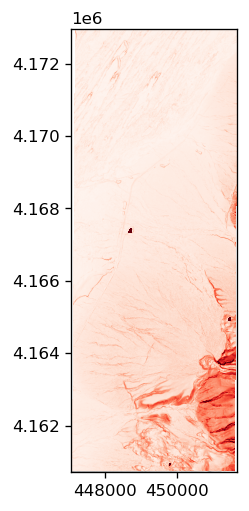

In [3]:
#Visualize the result - Slope magnitude
f,axs = plt.subplots(1,1,dpi = 120)

HS.plotGrid(axs = axs, cmap = 'gray',vmin = 0, vmax = 255)
Smag.plotGrid(axs = axs, cmap = 'Reds',vmin = 0, vmax = 1, alpha = 1)

<AxesSubplot: >

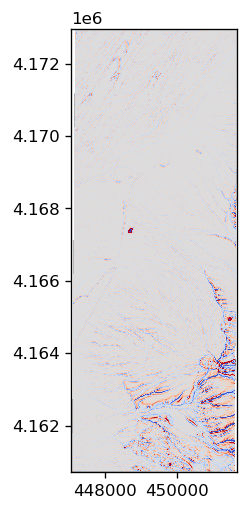

In [4]:
#Visualize the result - TPI 
f,axs = plt.subplots(1,1,dpi = 120)
HS.plotGrid(axs = axs, cmap = 'gray',vmin = 0, vmax = 255)
TPI.plotGrid(axs = axs, cmap = 'coolwarm',vmin = -0.25, vmax = 0.25, alpha = 1)

<AxesSubplot: >

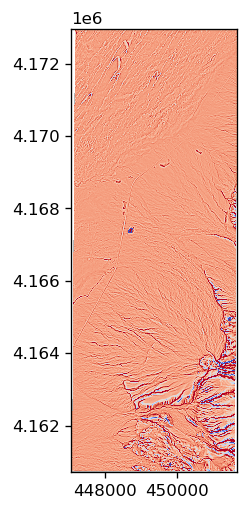

In [5]:
#Visualize the result - Curvature
f,axs = plt.subplots(1,1,dpi = 120)

HS.plotGrid(axs = axs, cmap = 'gray',vmin = 0, vmax = 255)
vmin,vmax = Crv.percentile([10,75])
Crv.plotGrid(axs = axs, cmap = 'coolwarm',vmin = vmin, vmax = vmax, alpha = 1)